In [4]:
import sys
sys.path.append('/Users/celia/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/celia/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as scio
import bandit_preprocessing as bp
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
record = pd.read_csv('/Users/celia/GitHub/mouse_bandit/session_record.csv',index_col=0)
ca_data = scio.loadmat('/Volumes/Neurobio/MICROSCOPE/Celia/data/imaging/Shay/k7_03142017_test/neuron_results.mat',squeeze_me = True, struct_as_record = False)
neuron = ca_data['neuron_results'] 

In [6]:
record.head(5)

Session ID Mouse ID                 Date  Phase  Left Reward Prob  \
0  11012016_K1       K1  2016-11-01 00:00:00    1.0               1.0   
1  11022016_K1       K1  2016-11-02 00:00:00    1.0               1.0   
2  11032016_K1       K1  2016-11-03 00:00:00    1.0               1.0   
3  11042016_K1       K1  2016-11-04 00:00:00    2.0               0.1   
4  11082016_K1       K1  2016-11-08 00:00:00    1.0               1.0   

   Right Reward Prob  Block Range Min  Block Range Max  No. Trials  \
0                1.0           1000.0           1000.0         8.0   
1                1.0           1000.0           1000.0        85.0   
2                1.0           1000.0           1000.0       104.0   
3                0.9             50.0             50.0        70.0   
4                1.0            500.0            500.0       118.0   

   No. Blocks  No. Rewards  p(high Port)  Decision Window Duration  \
0         0.0          8.0          0.00                      10.0   
1         0.0         85.0          0.00                      10.0   
2         0.0        104.0          0.00                       3.0   
3         1.0         50.0          0.83                       2.0   
4         0.0        118.0          0.00                       5.0   

   Min Inter-trial-interval  Left Solenoid Duration  Right Solenoid Duration  
0                       0.5                    35.0                     35.0  
1                       0.5                    35.0                     35.0  
2                       1.0                    35.0                     35.0  
3                       1.0                    35.0                     35.0  
4                       1.0                    60.0                     60.0

In [7]:
session_name  = '03142017_K7'
mouse_id = 'K7'

record[record['Session ID'] == session_name]

Session ID Mouse ID                 Date  Phase  Left Reward Prob  \
676  03142017_K7       K7  2017-03-14 00:00:00    2.0               0.8   

     Right Reward Prob  Block Range Min  Block Range Max  No. Trials  \
676                0.2             50.0             50.0       519.0   

     No. Blocks  No. Rewards  p(high Port)  Decision Window Duration  \
676         7.0        378.0          0.89                       2.0   

     Min Inter-trial-interval  Left Solenoid Duration  Right Solenoid Duration  
676                       1.0                    35.0                     35.0

# Extract data from specific session

In [9]:
'''
load in trial data
'''
columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked',
           'Right Reward Prob','Left Reward Prob','Reward Given',
          'center_frame','decision_frame']

root_dir = '/Users/celia/GitHub/mouse_bandit/data/trial_data'

full_name = session_name + '_trials.csv'

path_name = os.path.join(root_dir,full_name)

trial_df = pd.read_csv(path_name,names=columns)

In [10]:
trial_df.head(5)

Elapsed Time (s)  Since last trial (s)  Trial Duration (s)  Port Poked  \
0            13.361                 1.547               0.384           2   
1            15.477                 1.719               0.397           2   
2            39.428                23.441               0.510           2   
3            48.378                 1.807               0.418           2   
4            55.984                 7.032               0.574           2   

   Right Reward Prob  Left Reward Prob  Reward Given  center_frame  \
0                0.8               0.2             1           636   
1                0.8               0.2             0           699   
2                0.8               0.2             0          1414   
3                0.8               0.2             0          1685   
4                0.8               0.2             0          1908   

   decision_frame  
0             647  
1             711  
2            1429  
3            1697  
4            1926

# convert to feature matrix

In [7]:
feature_matrix = bp.create_feature_matrix(trial_df,10,mouse_id,session_name,feature_names='Default',imaging=True)

In [8]:
feature_matrix.head(2)

Mouse ID   Session ID  Trial  Block Trial  Block Reward  Port Streak  \
0       K7  03142017_K7   11.0         11.0           3.0          2.0   
1       K7  03142017_K7   12.0         12.0           3.0          3.0   

   Reward Streak  10_Port  10_Reward  10_ITI       ...        1_ITI  \
0            2.0      1.0        1.0   1.547       ...        1.714   
1           -1.0      1.0        0.0   1.719       ...        1.641   

   1_trialDuration  0_ITI  0_trialDuration  Decision  Switch  Higher p port  \
0            0.411  1.641            0.378       0.0     0.0            1.0   
1            0.378  1.391            0.443       0.0     0.0            1.0   

   Reward  center_frame  decision_frame  
0     0.0        2642.0          2653.0  
1     1.0        2695.0          2708.0  

[2 rows x 55 columns]

In [9]:
feature_matrix[['10_Port','10_ITI','10_trialDuration']].head(5)

10_Port  10_ITI  10_trialDuration
0      1.0   1.547             0.384
1      1.0   1.719             0.397
2      1.0  23.441             0.510
3      1.0   1.807             0.418
4      1.0   7.032             0.574

## function to get frames based on one or two conditions
    First define function so it can take multiple conditions (Reward, Switch, etc.) and the desired identity (0,1)
    May just want to make function for each number of conditions desired


In [10]:
def extract_frames(df, cond1_name, cond1=False, cond2_name=False, cond2=False, frame_type='decision_frame'):
    if type(cond2_name)==str:
        frames = (df[((df[cond1_name] == cond1) 
                    & (df[cond2_name] == cond2))][frame_type])
        return frames
    else:
        frames =(df[(df[cond1_name] == cond1)][frame_type])
        return frames

### Set the parameters to input into extract_frames function
    The rest of the notebook is set up for a comparison between 2 different states of a condition (a and b), so define those here

In [42]:
cond1_name = 'Switch'
cond1_a = 1
cond1_b = 0
cond2_name = 'Decision'
cond2 = 0

conditions = [cond1_a, cond1_b]

### Extract the frames for the specified conditions and create arrays containing frames for beginning and end of window of interest
    Currently set up so window spans from 10 frames before center poke to 10 frames after decision poke

In [43]:
extension = 30

frames_center_a = extract_frames(feature_matrix, cond1_name, cond1_a, cond2_name, cond2, 'center_frame')
frames_decision_a = extract_frames(feature_matrix, cond1_name, cond1_a, cond2_name, cond2, 'decision_frame')

frames_center_b = extract_frames(feature_matrix, cond1_name, cond1_b, cond2_name, cond2, 'center_frame')
frames_decision_b = extract_frames(feature_matrix, cond1_name, cond1_b, cond2_name, cond2, 'decision_frame')

start_stop_times_a = [[frames_center_a - extension], [frames_decision_a + extension]] # start 10 frames before center poke
start_stop_times_b = [[frames_center_b - extension], [frames_decision_b + extension]] # start 10 frames before center poke


### Set up some other parameters to be used in the rest of the script
    --nNeurons = number of neurons output by CNMF-e
        Redefined as number of neurons after some initial processing:
    --nan_neurons = any neurons containing NaNs in their calcium traces
    --good_neurons = neurons not containing NaNs -- used to redefine nNeurons
    --nTrials = [a,b] = number of trials in first condition, number in second condition
    --window_lengths -- max_window = find window length (number of frames) required to capture center poke to decision poke for all trials (just take maximum length trial across all conditions)

In [11]:
#plt.plot(neuron.C_raw[0, preStart:trialDecision])
nNeurons = neuron.C.shape[0]

# remove neurons that have NaNs
nan_neurons = np.where(np.isnan(neuron.C_raw))[0]
nan_neurons = np.unique(nan_neurons)
good_neurons = [x for x in range(0, nNeurons) if x not in nan_neurons]

nNeurons = len(good_neurons) # redefine number of neurons
nTrials = [len(start_stop_times_a[0][0]), len(start_stop_times_b[0][0])] # number of trials

# iterate through to determine duration between preStart and postDecision for each trial
window_length_a = []
window_length_b = []
for i in range(0,nTrials[0]):
    window_length_a.append((start_stop_times_a[1][0].iloc[i] - start_stop_times_a[0][0].iloc[i]))
for i in range(0,nTrials[1]):
    window_length_b.append((start_stop_times_b[1][0].iloc[i] - start_stop_times_b[0][0].iloc[i]))

# find longest window between preStart and postDecision and set as length for all trials
max_window = int([max((max(window_length_a), max(window_length_b)))][0])

NameError: name 'start_stop_times_a' is not defined

In [ ]:
# trying to normalize...
norm_trace = np.zeros((len(good_neurons),neuron.C_raw.shape[1]))
i = 0
for iNeuron in good_neurons:
    norm_trace[i,:] = (neuron.C_raw[iNeuron,:] - neuron.C_raw[iNeuron,:].min()) / (neuron.C_raw[iNeuron,:].max() - neuron.C_raw[iNeuron,:].min())
    i+=1

### Aligned to center poke
    Pull out segements of calcium traces in designated window of frames. Calculate mean fluorescence for each neuron across all trials, and plot it. Normalize fluorescence for each neuron.
    -- aligned_start = (number of trials x number frames x number of neurons x 2 (condition a and b)
    -- mean_center_poke = mean fluorescence for each neuron across all trials aligned to center poke
    -- norm_mean_center = normalized mean aligned to center poke

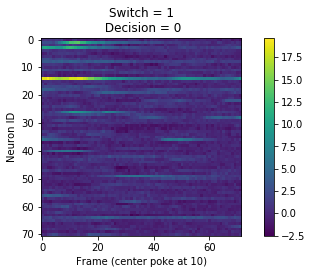

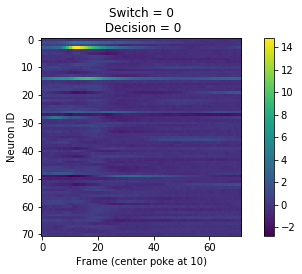

In [45]:
start_stop_times = [start_stop_times_a, start_stop_times_b]
aligned_start = np.zeros((np.max(nTrials), max_window, nNeurons, 2))
mean_center_poke = np.zeros((max_window, nNeurons, 2))
norm_mean_center = np.zeros((mean_center_poke.shape[0], nNeurons, 2))

for i in [0,1]:

    # create array containing segment of raw trace for each neuron for each trial 
    # aligned to center poke
    count = 0
    for iNeuron in good_neurons:
        for iTrial in range(0,nTrials[i]):
            aligned_start[iTrial,:, count, i] = neuron.C_raw[iNeuron, int(start_stop_times[i][0][0].iloc[iTrial]):(int(start_stop_times[i][0][0].iloc[iTrial])+max_window)]
        count = count+1

    # take mean of fluorescent traces across all trials for each neuron, then normalize for each neuron
    mean_center_poke[:,:,i]= np.mean(aligned_start[0:nTrials[i],:,:,i], axis=0)

    for iNeuron in range(0,nNeurons):
        norm_mean_center[:,iNeuron, i] = (mean_center_poke[:,iNeuron, i] - np.min(np.min(mean_center_poke, axis=0)[iNeuron][i]))/(np.max(np.max(mean_center_poke,axis=0)[iNeuron][i]) - np.min(np.min(mean_center_poke,axis=0)[iNeuron][i]))
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,i+1)  
    plt.imshow(np.transpose(mean_center_poke[:,:,i])), plt.colorbar()
    plt.xlabel('Frame (center poke at 10)')
    plt.ylabel('Neuron ID')
    plt.title("%s = %s\n %s = %s" % (cond1_name, conditions[i], cond2_name, cond2)) 

### Plot heatmap for normalized fluorescence mean traces

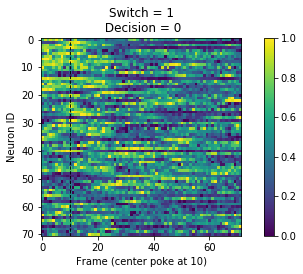

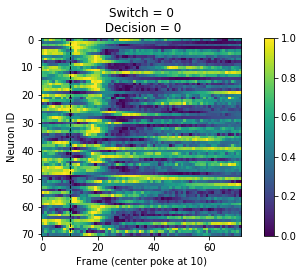

In [46]:
# heatmap for all neurons (each neuron represented by avg fluorescence across all trials)
for i in [0,1]:
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,i+1)  
    plt.imshow(np.transpose(norm_mean_center[:,:,i])), plt.colorbar()
    plt.axvline(x=10, color='k', linestyle = '--', linewidth=.9)
    plt.xlabel('Frame (center poke at %s)' % extension)
    plt.ylabel('Neuron ID')
    title = "%s = %s\n %s = %s\nNum trials = %.0f" % (cond1_name, conditions[i], cond2_name, cond2, nTrials_1[i])
    plt.title(title)
    plt.axis('tight')

### heatmap for calcium traces of a single neuron across all trials
    white dashed line for center poke time
    white vertical lines for decision poke time -- need something more subtle

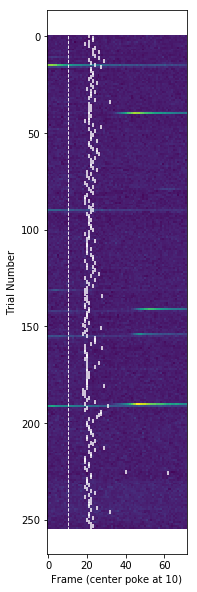

In [47]:
sample_neuron = 10

plt.figure(figsize=(10,10))
plt.imshow(aligned_start[0:nTrials[1],:,sample_neuron, 1])
plt.axvline(x=extension, color='white', linestyle = '--', linewidth=.9)
plt.ylabel('Trial Number')
plt.xlabel('Frame (center poke at 10)')
plt.scatter((frames_decision_b)-(frames_center_b)+extension,range(0,nTrials[1]), color='white', marker = '|', s=10)
plt.title('%s = %s\n%s = %s\nNeuron ID = %s' % (cond1_name, conditions_1[0], cond2_name, cond2_a, sample_neuron))
plt.axis('tight')

## aligned to decision poke
    Same process as for aligned to center poke
    Need to confirm alignment is correct but is better than before

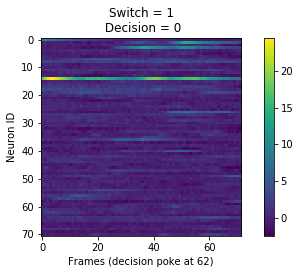

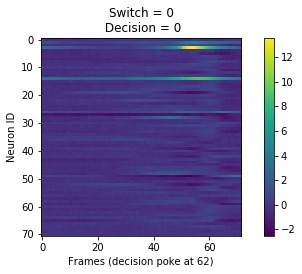

In [48]:
aligned_decision = np.zeros((np.max(nTrials), max_window, nNeurons, 2))
mean_decision = np.zeros((max_window, nNeurons, 2))
norm_mean_decision = np.zeros((mean_decision.shape[0], nNeurons, 2))
norm_test = np.zeros((mean_decision.shape[0], nNeurons, 2))

for i in [0,1]:

    # create array containing segment of raw trace for each neuron for each trial 
    # aligned to decision poke
    count = 0
    for iNeuron in good_neurons:
        for iTrial in range(0,nTrials[i]):
            aligned_decision[iTrial,:, count, i] = neuron.C_raw[iNeuron, int(start_stop_times[i][1][0].iloc[iTrial])-max_window:(int(start_stop_times[i][1][0].iloc[iTrial]))]
        count = count+1

    # take mean of fluorescent traces across all trials for each neuron, then normalize for each neuron
    mean_decision[:,:,i]= np.mean(aligned_decision[0:nTrials[i],:,:,i], axis=0)

    #count = 0
    for iNeuron in range(0,nNeurons):
        norm_mean_decision[:,iNeuron, i] = (mean_decision[:,iNeuron, i] - np.min(np.min(mean_decision, axis=0)[iNeuron][i]))/(np.max(np.max(mean_decision,axis=0)[iNeuron][i]) - np.min(np.min(mean_decision,axis=0)[iNeuron][i]))
        #norm_test[:,count,i] = (mean_decision[:,count, i] - np.min(neuron.C_raw, axis=1)[iNeuron])/(np.max(neuron.C_raw,axis=1)[iNeuron] - np.min(neuron.C_raw,axis=1)[iNeuron])
        #count = count+1
        
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,i+1)  
    plt.imshow(np.transpose(mean_decision[:,:,i])), plt.colorbar()
    plt.xlabel('Frames (decision poke at %s)' % (max_window-10))
    plt.ylabel('Neuron ID')
    plt.title("%s = %s\n %s = %s" % (cond1_name, conditions[i], cond2_name, cond2))

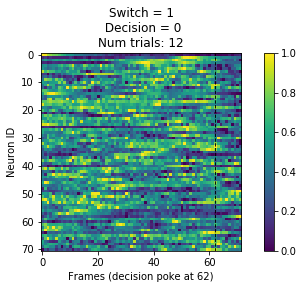

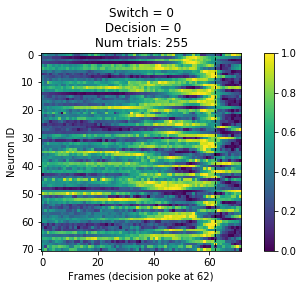

In [50]:
# heatmap for all neurons (each neuron represented by avg fluorescence across all trials)
for i in [0,1]:
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,i+1) 
    plt.imshow(np.transpose(norm_mean_decision[:,:,i])), plt.colorbar()
    plt.axvline(x=max_window-10, color='k', linestyle = '--', linewidth=.9)
    plt.xlabel('Frames (decision poke at %s)' % (max_window-10))
    plt.ylabel('Neuron ID')
    title = "%s = %s\n %s = %s" % (cond1_name, conditions[i], cond2_name, cond2)
    plt.title(title + '\nNum trials: %.0f' % nTrials[i])

## plot the difference between two different conditions
    Heatmaps of the subtraction of normalized mean traces of two different states of a condition

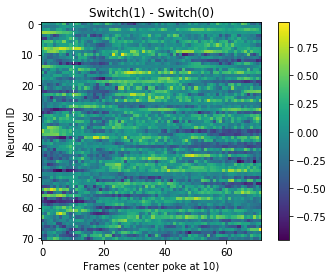

In [51]:
# plot the difference between two conditions for aligned to center poke
plt.imshow(np.transpose(norm_mean_center[:,:,0] - norm_mean_center[:,:,1])), plt.colorbar()
plt.axvline(x=10, color='white', linestyle = '--', linewidth=.9)
plt.ylabel('Neuron ID')
plt.xlabel('Frames (center poke at 10)')
plt.title('%s(%s) - %s(%s)' % (cond1_name, conditions[0], cond1_name, conditions[1]))
#plt.title('%s(%s) - %s(%s)\n %s = %s' % (cond1_name, conditions_1[0], cond1_name, conditions_1[1], cond2_name, cond2_a))


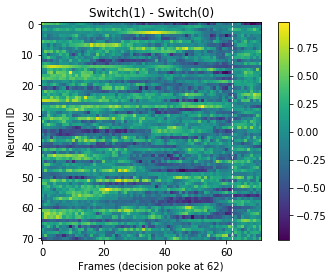

In [52]:
# plot the difference between two conditions for aligned to decision poke
plt.imshow(np.transpose(norm_mean_decision[:,:,0] - norm_mean_decision[:,:,1])), plt.colorbar()
plt.axvline(x=max_window-10, color='white', linestyle = '--', linewidth=.9)
plt.xlabel('Frames (decision poke at %s)' % (max_window-10))
plt.ylabel('Neuron ID')
plt.title('%s(%s) - %s(%s)' % (cond1_name, conditions[0], cond1_name, conditions[1]))
#plt.title('%s(%s) - %s(%s)\n %s = %s' % (cond1_name, conditions_1[0], cond1_name, conditions_1[1], cond2_name, cond2_a))


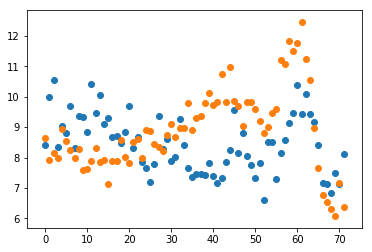

In [54]:
sum_decision_0 = np.sum(norm_mean_decision[:,(max_window-20):(max_window),0], axis=1)
sum_decision_1 = np.sum(norm_mean_decision[:,(max_window-20):(max_window),1], axis=1)

plt.scatter(range(0,72), sum_decision_0); plt.scatter(range(0,72), sum_decision_1)

In [12]:
sum_center_0 = np.sum(norm_mean_center[:, 0:20, 0], axis=1)
sum_center_1 = np.sum(norm_mean_center[:, 0:20, 1], axis=1)

plt.scatter(range(0,72), sum_center_0); plt.scatter(range(0,72), sum_center_1)

NameError: name 'norm_mean_center' is not defined

trying to figure out normalization along the same scale

In [ ]:
agg_max = np.array([np.max(mean_center_poke_1,axis=0), np.max(mean_center_poke_2,axis=0)])
agg_max = np.max(np.max(agg_max, axis = 2), axis=0)

agg_min = np.array([np.min(mean_center_poke_1,axis=0), np.min(mean_center_poke_2,axis=0)])
agg_min = np.min(np.min(agg_min, axis = 2), axis=0)

for i in [0,1]:

    for iNeuron in range(0,nNeurons):
        norm_mean_center_1[:,iNeuron, i] = (mean_center_poke_1[:,iNeuron, i] - agg_min[iNeuron])/(agg_max[iNeuron] - agg_min[iNeuron])
        
    for iNeuron in range(0,nNeurons):
        norm_mean_center_2[:,iNeuron, i] = (mean_center_poke_2[:,iNeuron, i] - agg_min[iNeuron])/(agg_max[iNeuron] - agg_min[iNeuron])
    